In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from sklearn.utils import shuffle

from matplotlib import pyplot

from tensorflow.keras import backend as backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from xgboost import XGBClassifier

import missingno as msno

from vime_self import vime_self
from vime_semi import vime_semi
from vime_utils import perf_metric

In [2]:
mergedData = pd.read_excel('../TabellaFinaleSenzaNaN.xlsx', sheet_name=None)
df = mergedData['Sheet1'].iloc[:, 1:]

In [3]:
# LE TRASFORMAZIONI SONO STATE MESSE IN FillNaN.ipynb

### Set the parameters and define output

-   label_no: Number of labeled data to be used
-   model_sets: supervised model set (mlp, logit, or xgboost)
-   p_m: corruption probability for self-supervised learning
-   alpha: hyper-parameter to control the weights of feature and mask losses
-   K: number of augmented samples
-   beta: hyperparameter to control supervised and unsupervised loss
-   label_data_rate: ratio of labeled data
-   metric: prediction performance metric (either acc or auc)

In [4]:
# Experimental parameters
label_no = 176
model_sets = ['logit', 'xgboost', 'mlp']
  
# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.32

# Metric
metric = 'acc'
  
# Define output
results = np.zeros([len(model_sets)+2])

In [5]:
synthetic_data = '../synthetic_data_-1_def.csv'

In [6]:
dfs = pd.read_csv(synthetic_data)

In [7]:
frames = [df, dfs]

df = pd.concat(frames)

In [8]:
df.drop(columns=['DATA'], inplace=True)

In [9]:
'''df.loc[df['Outcome'] == -1, 'Outcome'] = np.nan
for col in df:
    #get dtype for column
    dt = df[col].dtype 
    #check if it is a number
    if col != 'Outcome':
        if dt == int or dt == float:
            df.loc[df[col]<0, col] = np.nan
        else:
            df.loc[df[col] == "", col] = np.nan'''

'df.loc[df[\'Outcome\'] == -1, \'Outcome\'] = np.nan\nfor col in df:\n    #get dtype for column\n    dt = df[col].dtype \n    #check if it is a number\n    if col != \'Outcome\':\n        if dt == int or dt == float:\n            df.loc[df[col]<0, col] = np.nan\n        else:\n            df.loc[df[col] == "", col] = np.nan'

In [10]:
#df = shuffle(df, random_state=42)

In [11]:
#df = df[[
        #'Unnamed: 0',
        #'HDN_CODE', 
        #'ETA',
        #'ASCVD_Score',
        #'Charlson_Totale',
        #'BMI',
        #'BMI_Ricovero', 
        #'BMIPostRicovero',
        #'Fumatore',
        #'GlobuliBianchi',
        #'Linfociti_Assoluti',
        #'GPT_ALT', 
        #'D_dimero',
        #'PCR',
        #'DurataRicovero',
        #'Stress level',
        #'Depression level',
        #'Anxiety level',
        #'FrailtyPhenotypeBool',
        #'Resilience',
        #'Outcome'
        #]]

In [12]:
#X = df[(df['FrailtyPhenotypeBool'] != -1) & (df['Resilience'] != -1)]
X = df[df['Outcome']!=-1]
X.drop(columns=['FrailtyPhenotypeBool', 'Resilience', 'Outcome'], inplace=True)

y = df[df['Outcome']!=-1]['Outcome']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)#, shuffle=False)

x_unlab = df[df['Outcome']==-1]
x_unlab.drop(columns=['FrailtyPhenotypeBool', 'Resilience', 'Outcome'], inplace=True)

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
#y_train = y_train.to_numpy()#.reshape(len(y_train), 1)
#y_test = y_test.to_numpy()#.reshape(len(y_test), 1)
x_unlab = x_unlab.to_numpy()

/home/gibbo/.local/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/gibbo/.local/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_unlab.shape)

#print(np.isnan(x_train).any())
#print(np.isnan(y_train).any())
#print(np.isnan(x_test).any())
#print(np.isnan(y_test).any())
#print(np.isnan(x_unlab).any())
y  # viene utilizzato il one-hot encoder

(1332, 76)
(1332,)
(445, 76)
(445,)
(3774, 76)


0       1
1       0
4       3
9       0
14      1
       ..
4987    1
4989    1
4991    1
4995    1
4996    1
Name: Outcome, Length: 1777, dtype: int64

In [14]:
# Logistic regression
model = LogisticRegression()
model.fit(x_train, y_train)
  
  # Predict on x_test
y_test_hat = model.predict(x_test) 
results[0] = accuracy_score(y_test, y_test_hat)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [15]:
# XGBoost
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

model = XGBClassifier()
model.fit(x_train, y_train)

y_test_hat = model.predict(x_test)
results[1] = accuracy_score(y_test, y_test_hat)

/home/gibbo/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


(1332, 76)
(1332,)
(445, 76)
(445,)
[10:08:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [16]:
print(results[1])

0.8584269662921349


In [17]:
def convert_vector_to_matrix(vector):
    # Parameters
    no = len(vector)
    dim = len(np.unique(vector))
    # Define output
    matrix = np.zeros([no,dim])
    
    # Convert vector to matrix
    for i in range(dim):
        idx = np.where(vector == i)
        matrix[idx, i] = 1
    
    return matrix

def mlp(x_train, y_train, parameters):
    # Convert labels into proper format
    if len(y_train.shape) == 1:
        y_train = convert_vector_to_matrix(y_train)
    
    idx = np.random.permutation(len(x_train[:, 0]))
    train_idx = idx[:int(len(idx)*0.9)]
    valid_idx = idx[int(len(idx)*0.9):]
    
    # Validation set
    x_valid = x_train[valid_idx, :]
    y_valid = y_train[valid_idx, :]
    
    # Training set
    x_train = x_train[train_idx, :]
    y_train = y_train[train_idx, :]  
    
    # Reset the graph
    backend.clear_session()
    
    # Define network parameters
    hidden_dim = parameters['hidden_dim']
    epochs_size = parameters['epochs']
    act_fn = parameters['activation']
    batch_size = parameters['batch_size']
    
    # Define basic parameters
    data_dim = len(x_train[0, :])
    label_dim = len(y_train[0, :])

    # Build model
    model = Sequential()
    #model.add(Dropout(0.2, input_shape=(data_dim,)))
    model.add(Dense(hidden_dim, 
                    input_dim = data_dim,
                    activation = act_fn))
    #model.add(LeakyReLU())
                    #kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5)))
    #model.add(Dropout(0.2))
    model.add(Dense(hidden_dim,
                    activation = act_fn))
    #model.add(LeakyReLU())
                    #kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5)))
    #model.add(Dropout(0.2))
    model.add(Dense(label_dim, 
                    activation = 'softmax'))
                    #kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5)))
    
    optimizer = Adam(learning_rate=0.000001)
    
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, 
                    metrics = ['accuracy'])

    es = EarlyStopping(monitor='loss', mode = 'min', 
                         verbose = 1, restore_best_weights=True, patience=50)
    
    #print(x_train)
    #print(x_train.shape)
    #print(y_train)
    #print(y_train.shape)

      # Fit model on training dataset
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                epochs = epochs_size, batch_size = batch_size, 
                verbose = 0)#, callbacks=[es])
    
    print('\n\n\t')
    print(history.history)
    print('\n\n')
    
    #_, train_acc = model.evaluate(x_train, y_train, verbose=0)
    #_, test_acc = model.evaluate(x_test, y_test, verbose=0)
    #print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    
    return model, history

/home/gibbo/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '




	
{'loss': [92684.83896337646, 92319.0997234975, 91960.6614148581, 91588.62134808014, 91227.95808117696, 90876.20986800919, 90489.95620956803, 90152.31628234558, 89779.0753404111, 89416.9303135434, 89053.43946290693, 88683.12762155676, 88331.04581855175, 87947.28115218072, 87607.07723810518, 87252.45590306762, 86894.01292518781, 86534.42673987897, 86177.83137260017, 85846.43339159015, 85494.68708263773, 85129.57222323664, 84775.57918144825, 84437.31612583472, 84081.50968410893, 83726.49709150668, 83373.40237635643, 83021.0717080551, 82676.30833941986, 82309.9206620409, 81978.23440760643, 81614.61763094741, 81270.29520555092, 80926.17929622286, 80559.55624608723, 80217.80756990818, 79867.7439873748, 79514.70482053423, 79159.07609035893, 78826.47034119365, 78462.71307322099, 78101.97094115191, 77770.46936300084, 77422.8463519929, 77060.85614044241, 76700.03887990401, 76358.7082898581, 76002.91380164858, 75659.02268103088, 75306.49047892321, 74950.87374791318, 74599.57113418197, 74240.2

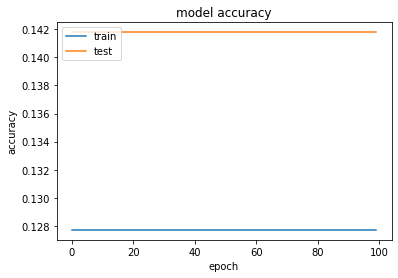

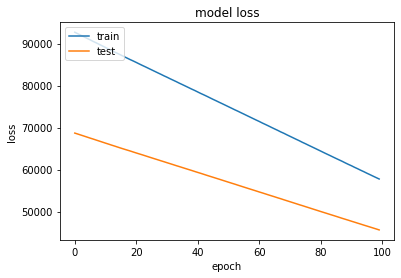

[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.5405498e-17 3.9674335e-17 2.0938212e-30]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               7700      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 18,204
Trainable params: 18,204
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# MLP
mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 100

y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

#print(x_train.shape)
#print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)

model, history = mlp(x_train, y_train, mlp_parameters)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

y_test_hat_mlp = model.predict(x_test)

print(y_test_hat_mlp)

print(model.summary())

results[2] = perf_metric(metric, y_test, y_test_hat_mlp)

### Train & Test VIME-Self
Train self-supervised part of VIME framework only
- Check the performance of self-supervised part of VIME framework.

Train on 3774 samples
Epoch 1/10
3774/3774 [==============================] - 0s 28us/sample - loss: 80130788891.9470 - mask_loss: 2990.0923 - feature_loss: 40060997632.0000
Epoch 2/10
3774/3774 [==============================] - 0s 12us/sample - loss: 80130771765.5877 - mask_loss: 425.6400 - feature_loss: 40135454720.0000
Epoch 3/10
3774/3774 [==============================] - 0s 12us/sample - loss: 80130773736.5299 - mask_loss: 391.1095 - feature_loss: 40100413440.0000
Epoch 4/10
3774/3774 [==============================] - 0s 12us/sample - loss: 80130771926.2151 - mask_loss: 364.8129 - feature_loss: 40090271744.0000
Epoch 5/10
3774/3774 [==============================] - 0s 12us/sample - loss: 80130772994.1706 - mask_loss: 368.5934 - feature_loss: 40091852800.0000
Epoch 6/10
3774/3774 [==============================] - 0s 12us/sample - loss: 80130772651.2093 - mask_loss: 357.2311 - feature_loss: 39586770944.0000
Epoch 7/10
3774/3774 [==============================] - 0s 10us/sample 

/home/gibbo/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '




	
{'loss': [22208.763177887624, 22031.654779450124, 21862.80013890338, 21693.178663658182, 21521.75973953986, 21354.3296738053, 21180.521432204718, 21003.22983944595, 20833.95491509286, 20662.775025433013, 20493.88565578047, 20324.81779691413, 20148.85850440839, 19979.49026046014, 19803.90120089472, 19639.485307543822, 19470.322061834828, 19303.42096854132, 19128.18271011582, 18952.238941530155, 18785.286842002297, 18620.839959502817, 18449.865989213795, 18273.960657899886, 18101.650657997703, 17930.89411714837, 17762.321398294032, 17595.109533141174, 17423.925702994573, 17247.959577811976, 17088.28452368531, 16906.38990928892, 16735.028824081804, 16566.842365041997, 16398.536603975375, 16228.481320592915, 16059.367873865296, 15883.437917362271, 15714.81076289258, 15549.042000339106, 15371.1344069543, 15201.449319829924, 15037.247530878287, 14864.823400328673, 14695.64063641225, 14521.894064978089, 14354.066896976732, 14180.47353662354, 14014.003999993478, 13829.218060374062, 13660.3

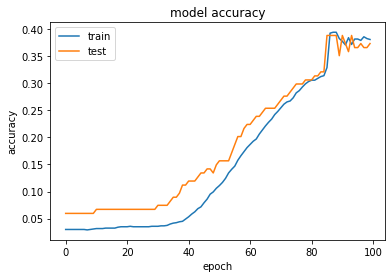

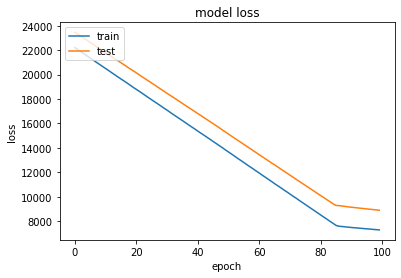

In [19]:
# Train VIME-Self
vime_self_parameters = dict()
vime_self_parameters['batch_size'] = 128
vime_self_parameters['epochs'] = 10
vime_self_encoder = vime_self(x_unlab, p_m, alpha, vime_self_parameters)
  
# Save encoder
if not os.path.exists('save_model'):
    os.makedirs('save_model')

file_name = './save_model/encoder_model.h5'

vime_self_encoder.save(file_name)

# Test VIME-Self
x_train_hat = vime_self_encoder.predict(x_train)  # entrambi questi ritornavano nan
x_test_hat = vime_self_encoder.predict(x_test)
      
model, history = mlp(x_train_hat, y_train, mlp_parameters)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

y_test_hat = model.predict(x_test_hat)

results[3] = perf_metric(metric, y_test, y_test_hat)

### Train & Test VIME

Train semi-supervised part of VIME framework on top of trained self-supervised encoder
- Check the performance of entire part of VIME framework.

In [20]:
# Train VIME-Semi
vime_semi_parameters = dict()
vime_semi_parameters['hidden_dim'] = 100
vime_semi_parameters['batch_size'] = 128
vime_semi_parameters['iterations'] = 1000
y_test_hat = vime_semi(x_train, y_train, x_unlab, x_test, 
                       vime_semi_parameters, p_m, K, beta, file_name)

# Test VIME
results[4] = perf_metric(metric, y_test, y_test_hat)

/home/gibbo/.local/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/gibbo/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Iteration: 0/1000, Current loss: 4011.0757


/home/gibbo/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Iteration: 100/1000, Current loss: 100.3056
Iteration: 200/1000, Current loss: 19.494
Iteration: 300/1000, Current loss: 334.831
INFO:tensorflow:Restoring parameters from ./save_model/class_model.ckpt


### Report Prediction Performances

- 3 Supervised learning models
- VIME with self-supervised part only
- Entire VIME framework

In [21]:
for m_it in range(len(model_sets)):  
    
    model_name = model_sets[m_it]  
    
    print('Supervised Performance, Model Name: ' + model_name + 
        ', Performance: ' + str(results[m_it]))
    
print('VIME-Self Performance: ' + str(results[m_it+1]))
  
print('VIME Performance: '+ str(results[m_it+2]))

Supervised Performance, Model Name: logit, Performance: 0.7370786516853932
Supervised Performance, Model Name: xgboost, Performance: 0.8584269662921349
Supervised Performance, Model Name: mlp, Performance: 0.11685393258426967
VIME-Self Performance: 0.3438202247191011
VIME Performance: 0.604494382022472


In [22]:
# prova a vedere se i modelli di MLP sono veramente identici a quelli tradotti o c'è 
# qualcosa da modificare

# mlp e vime self non danno sempre uguale

In [23]:
y_test_hat_mlp

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       ...,
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.5405498e-17, 3.9674335e-17, 2.0938212e-30],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)

In [24]:
#rnd_data = np.random.random((1000, 76))

In [25]:
#X_rnd = rnd_data[:, :-4]

In [26]:
#y_rnd = rnd_data[:,-4:]

In [27]:
#X_rnd = rnd_data[:, :-4]
#y_rnd = rnd_data[:,-4:]

#x_train_rnd, x_test_rnd, y_train_rnd, y_test_rnd = train_test_split(X_rnd, y_rnd, random_state=42, test_size=0.25)#, shuffle=False)

In [28]:
# MLP
'''mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 100

#y_test = to_categorical(y_test_rnd)
#y_train = to_categorical(y_train_rnd)

#print(x_train.shape)
#print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)

model, history = mlp(x_train_rnd, y_train_rnd, mlp_parameters)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

y_test_hat_mlp = model.predict(x_test_rnd)

print(y_test_hat_mlp)

print(model.summary())

print(perf_metric(metric, y_test_rnd, y_test_hat_mlp))'''

"mlp_parameters = dict()\nmlp_parameters['hidden_dim'] = 100\nmlp_parameters['epochs'] = 100\nmlp_parameters['activation'] = 'relu'\nmlp_parameters['batch_size'] = 100\n\n#y_test = to_categorical(y_test_rnd)\n#y_train = to_categorical(y_train_rnd)\n\n#print(x_train.shape)\n#print(y_train.shape)\n#print(x_test.shape)\n#print(y_test.shape)\n\nmodel, history = mlp(x_train_rnd, y_train_rnd, mlp_parameters)\n\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n# summarize history for loss\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n\ny_test_hat_mlp = model.predict(x_test_rnd)\n\nprint(y_test_hat_mlp)\n\nprint(model.summary())\n\nprint(perf_metric(metric, y_test_rnd, y_test